<a href="https://colab.research.google.com/github/josefernandezest98/training/blob/main/Change_Point_Detection/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Change Point detection

In [1]:
!pip install ruptures

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.6 MB/s eta 0:00:00


In [2]:
# Libraries
import pandas as pd
import numpy as np
import ruptures as rpt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from numpy.linalg import lstsq

# MatPlotLib style
plt.style.use('ggplot')

## 0. Signal creation

* Random signal created with ruptures

In [3]:
# generate signal
n_samples, dim, sigma = 1000, 3, 5
n_bkps = 4  # number of breakpoints
signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)

# 1D signal_0
d1_signal_0 = [signal[i][0] for i in range(len(signal))]
x0 = list(range(len(d1_signal_0)))

# 1D signal__1
d1_signal_1 = [signal[i][1] for i in range(len(signal))]
x1 = list(range(len(d1_signal_1)))

# 1D signal__2
d1_signal_2 = [signal[i][2] for i in range(len(signal))]
x2 = list(range(len(d1_signal_2)))

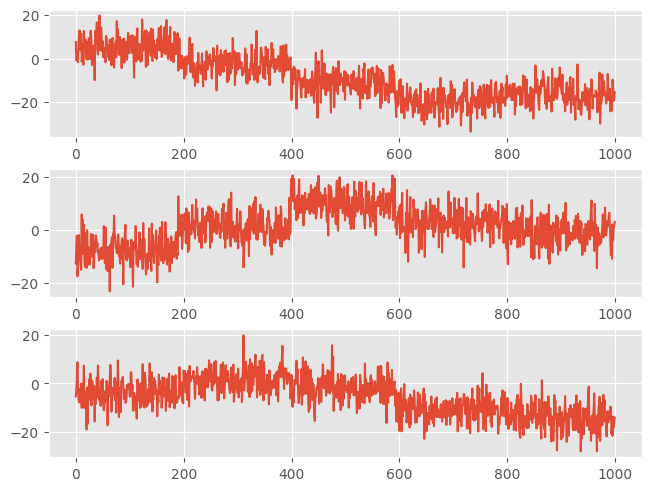

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, layout='constrained')

ax1.plot(x0,d1_signal_0)
ax2.plot(x1,d1_signal_1)
ax3.plot(x2,d1_signal_2)

* Synthetic datasets based on the project data's shape (without noise)

In [5]:
# Dataset 0

lists_d0 = []
for j in range(0,4501,500):
  lists_d0.append([i for i in range(j,j+500,20)])
for lista in lists_d0:
  lista.reverse()
lists_d0.reverse()

lists_d0_nr = []
for j in range(0,5001,500):
  lists_d0_nr.append(np.repeat(j,50).tolist())
lists_d0_nr.reverse()

final_list_d0 = []
for i in range(min(len(lists_d0),len(lists_d0_nr))):
  final_list_d0 = final_list_d0 + lists_d0_nr[i] + lists_d0[i]
final_list_d0 = final_list_d0 + lists_d0_nr[-1]

In [6]:
# Dataset 1

lists_d1 = []
for j in range(11):
  lists_d1.append([2000+5*i for i in range(51)])

lists_d1_r = []
for j in range(10):
  l = [2000+5*i for i in range(0,51,2)]
  l.reverse()
  lists_d1_r.append(l)
del l

final_list_d1 = []
for i in range(min(len(lists_d1),len(lists_d1_r))):
  final_list_d1 = final_list_d1 + lists_d1[i] + lists_d1_r[i]
final_list_d1 = final_list_d1 + lists_d1[-1]

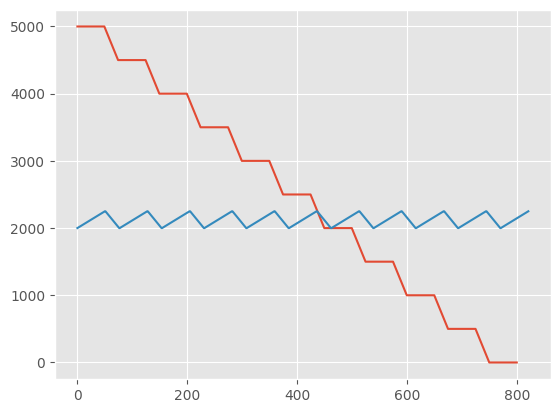

In [7]:
y_d0 = np.array(final_list_d0)
y_d1 = np.array(final_list_d1)
x_d0 = [i for i in range(len(y_d0))]
x_d1 = [i for i in range(len(y_d1))]
plt.plot(x_d0,y_d0)
plt.plot(x_d1,y_d1)

## 1. Algorithms

### 1.1 Piece wise linear-regression

In [8]:
def piece_wise_lr_cpd(data, columnName, peice_diff=100):

  st_idx, end_idx = 0, peice_diff
  coeff = []
  while end_idx<=data.shape[0]:

      X = [[x] for x in np.arange(peice_diff)]
      y = list(data.iloc[list(range(st_idx, end_idx, 1))][columnName])

      min_v, max_v = min(y), max(y)
      y = [(x-min_v)/(max_v-min_v) for x in y]

      model = LinearRegression()
      model.fit(X, y)

      coeff.extend([abs(model.coef_[0])]*peice_diff)
      #print(data.iloc[st_idx].index, data.iloc[end_idx].index, abs(model.coef_[0]))

      st_idx = end_idx
      end_idx = end_idx+peice_diff

  return coeff

* Signal

In [9]:
# dataframe creation
ts_df = pd.DataFrame(signal, columns=['series_1','series_2','series_3'])

# compute results
ts_df['coeff_1'] = piece_wise_lr_cpd(ts_df, 'series_1', peice_diff=200)
ts_df['coeff_2'] = piece_wise_lr_cpd(ts_df, 'series_2', peice_diff=200)
ts_df['coeff_3'] = piece_wise_lr_cpd(ts_df, 'series_3', peice_diff=200)

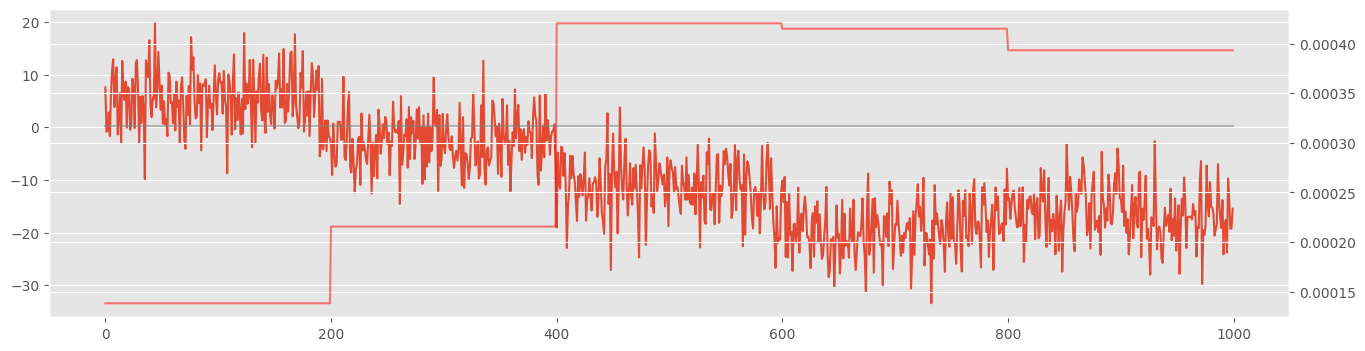

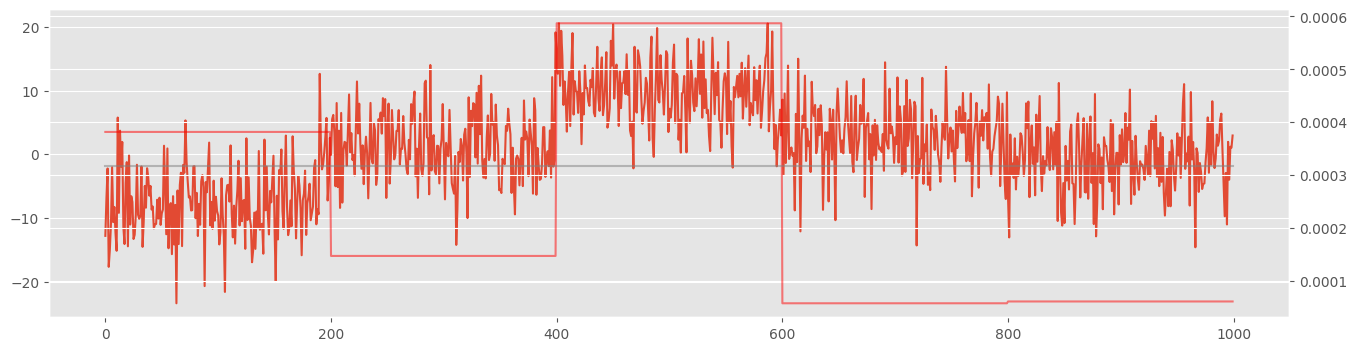

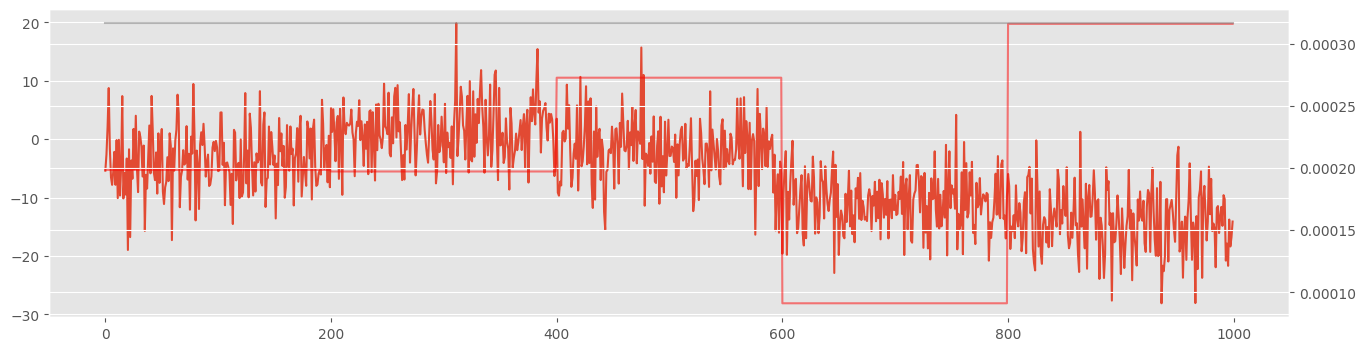

In [10]:
# plot the results
fig, ax1 = plt.subplots(figsize=(16,4))
ax2 = ax1.twinx()
ax1.plot(ts_df.index, ts_df.series_1)
ax2.plot(ts_df.index, ts_df.coeff_1, color='red', alpha=0.5)
ax2.plot(ts_df.index, [np.mean(ts_df.coeff_1)]*ts_df.shape[0], color='grey', alpha=0.5)
ax1.grid(axis='x')
plt.show()

# plot the results
fig, ax1 = plt.subplots(figsize=(16,4))
ax2 = ax1.twinx()
ax1.plot(ts_df.index, ts_df.series_2)
ax2.plot(ts_df.index, ts_df.coeff_2, color='red', alpha=0.5)
ax2.plot(ts_df.index, [np.mean(ts_df.coeff_1)]*ts_df.shape[0], color='grey', alpha=0.5)
ax1.grid(axis='x')
plt.show()

# plot the results
fig, ax1 = plt.subplots(figsize=(16,4))
ax2 = ax1.twinx()
ax1.plot(ts_df.index, ts_df.series_3)
ax2.plot(ts_df.index, ts_df.coeff_3, color='red', alpha=0.5)
ax2.plot(ts_df.index, [np.mean(ts_df.coeff_1)]*ts_df.shape[0], color='grey', alpha=0.5)
ax1.grid(axis='x')
plt.show()

This algorithm depends on the batch size, so it is discarded. We are not even going to test in the synthetic datasets.

### 1.2 Ruptures library

* Signal

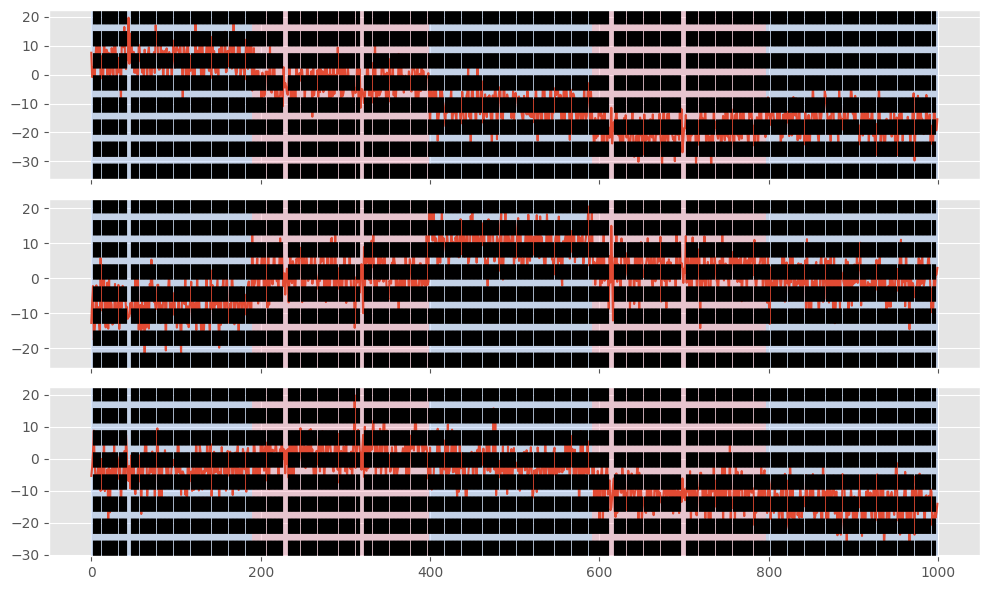

In [11]:
# detection
algo = rpt.Pelt(model="l2").fit(signal)
result = algo.predict(pen=10)

# display
rpt.display(signal, bkps, result)
plt.show()

* Synthetic datasets

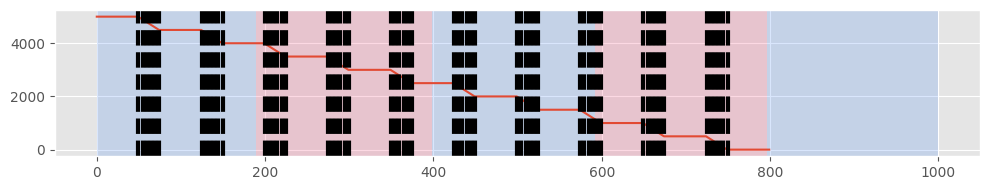

In [12]:
# fit
model = rpt.Pelt(model="l2")
model.fit(y_d0)
result = model.predict(pen=10)

# display
rpt.display(y_d0, bkps, result)
plt.show()

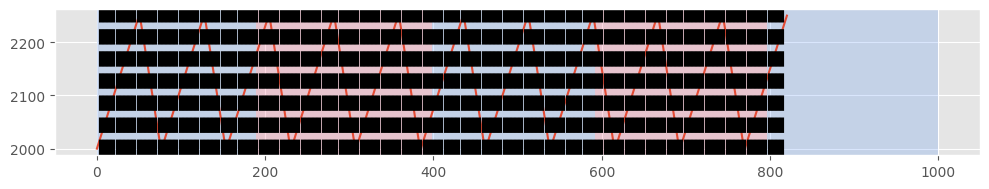

In [13]:
# fit
model = rpt.Pelt(model="l2")
model.fit(y_d1)
result = model.predict(pen=10)

# display
rpt.display(y_d1, bkps, result)
plt.show()

Let's take a look to the implementation in one changeing point interval with L2 cost.

In [14]:
# Least absolute derivation (L1)
def l1_cost(signal, start, end):
  subset = signal[start:end]
  med = np.median(subset, axis=0)
  return abs(subset - med).sum()

# Least squared deviation (L2)
def l2_cost(signal, start, end):
  subset = signal[start:end]
  return subset.var(axis=0).sum()*(end - start)

# function
def optimal_cp(signal, start, end):
        segment_cost = l2_cost(signal, start, end)
        if np.isinf(segment_cost) and segment_cost < 0:  # if cost is -inf
            return None, 0
        gain_list = list()
        for bkp in range(start, end, 5):
            if bkp - start >= 1 and end - bkp >= 1:
                gain = (
                    segment_cost - l2_cost(signal, start, bkp) - l2_cost(signal, bkp, end)
                )
                gain_list.append((gain, bkp))
        try:
            gain, bkp = max(gain_list)
        except ValueError:  # if empty sub_sampling
            return None, 0
        return gain_list, bkp, gain

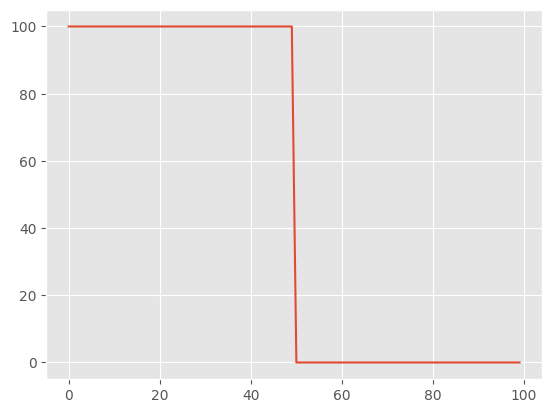

In [15]:
y_ = np.array(np.repeat(100,50).tolist() + np.repeat(0,50).tolist())
x_ = range(len(y_))

plt.plot(x_,y_)

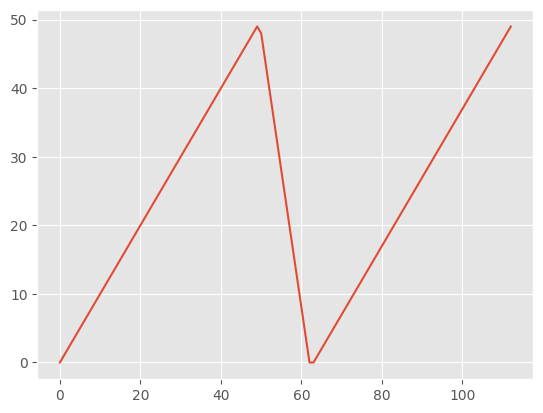

In [16]:
rev = [i for i in range(0,50,4)]
rev.reverse()
y__ = np.array([i for i in range(50)] + rev + [i for i in range(50)])
x__ = np.array([i for i in range(len(y__))])

plt.plot(x__,y__)

In [17]:
gain_list, bkp, gain = optimal_cp(y_, 0, len(y_)-1)
max(gain_list)

(247474.74747474756, 50)

In [18]:
gain_list, bkp, gain = optimal_cp(y__, 0, len(y__)-1)
max(gain_list)

(5277.952251552797, 20)

The first case works, because the changing point is in the 50th position. The second case does not work, there is no changing point in the 20th position. This is because L1 and L2 use the variance and standard deviation. In the second case it only would work with the monotony. It is probably that the autoregressive cost function will work.

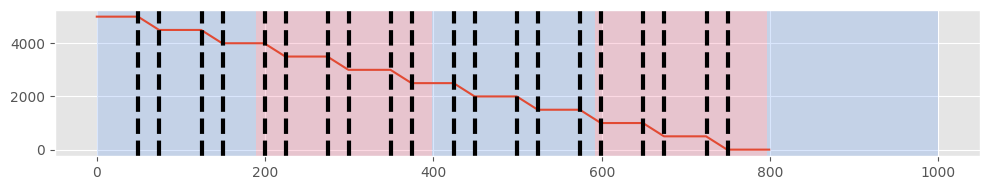

In [19]:
# fit
model = rpt.Pelt(model="ar")
model.fit(y_d0)
result = model.predict(pen=10)

# display
rpt.display(y_d0, bkps, result)
plt.show()

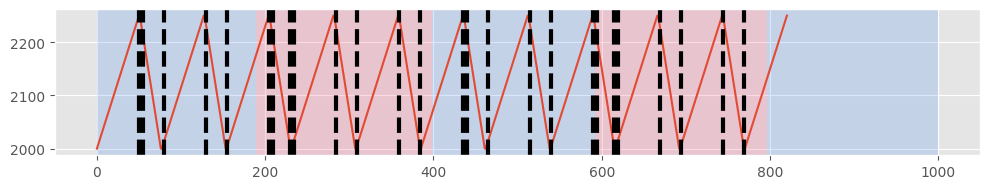

In [20]:
# fit
model = rpt.Pelt(model="ar")
model.fit(y_d1)
result = model.predict(pen=10)

# display
rpt.display(y_d1, bkps, result)
plt.show()

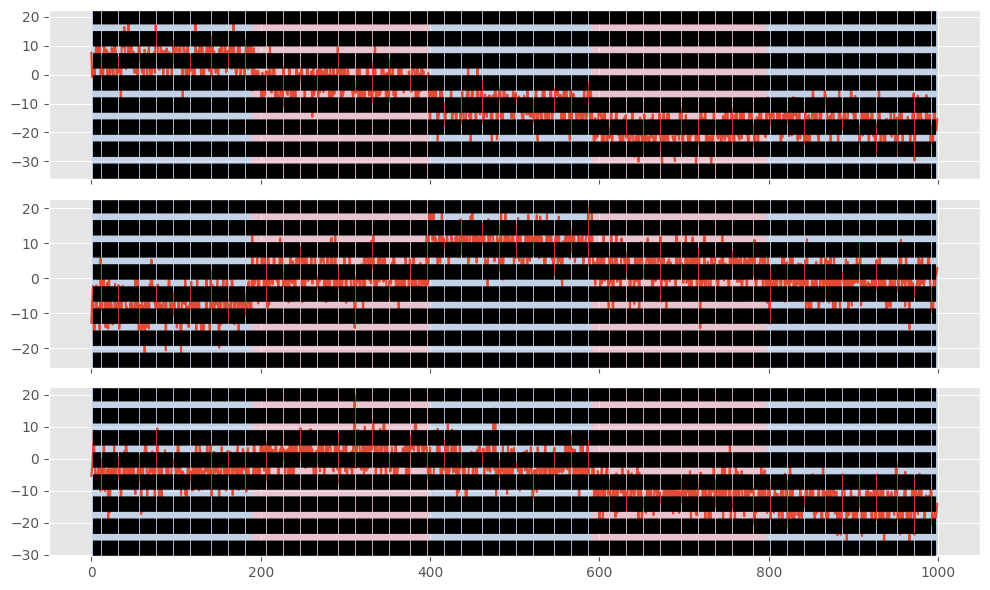

In [21]:
# detection
algo = rpt.Pelt(model="ar").fit(signal)
result = algo.predict(pen=10)

# display
rpt.display(signal, bkps, result)
plt.show()

It seems to do it. Now we have to implement it in PySpark and test in every cases to fit the tolerance.

In [22]:
from copy import deepcopy
from numpy.lib.stride_tricks import as_strided

y_d0_ps = y_d0.reshape((len(y_d0),1))
y_d1_ps = y_d1.reshape((len(y_d1),1))

signal_ = deepcopy(y_d0_ps)
signal_ = signal_.reshape(-1, 1)
n_samples, _ = signal_.shape
strides = (signal_.itemsize, signal_.itemsize)
order = 2
shape = (n_samples - order, order)
lagged = as_strided(signal_, shape=shape, strides=strides)
lagged_after_padding = np.pad(lagged, ((order, 0), (0, 0)), mode="edge")
covar = np.c_[lagged_after_padding, np.ones(n_samples)]
signal_[: order] = signal_[order]

In [23]:
# Least squares
def least_squares(signal, covar, start, end):
  subset = signal[start:end]
  y, X = signal[start:end], covar[start:end]
  _, residual, _, _ = lstsq(X, y, rcond=None)
  return residual.sum()

# function
def optimal_cp_ls(signal, start, end):

        signal_ = deepcopy(signal)
        signal_ = signal_.reshape(-1, 1)
        n_samples, _ = signal_.shape
        strides = (signal_.itemsize, signal_.itemsize)
        order = 2
        shape = (n_samples - order, order)
        lagged = as_strided(signal_, shape=shape, strides=strides)
        lagged_after_padding = np.pad(lagged, ((order, 0), (0, 0)), mode="edge")
        covar = np.c_[lagged_after_padding, np.ones(n_samples)]
        signal_[: order] = signal_[order]

        segment_cost = least_squares(signal_, covar, start, end)
        if np.isinf(segment_cost) and segment_cost < 0:  # if cost is -inf
            return None, 0
        gain_list = list()
        for bkp in range(start, end, 5):
            if bkp - start >= 1 and end - bkp >= 1:
                gain = (
                    segment_cost - least_squares(signal, covar, start, bkp) - least_squares(signal, covar, bkp, end)
                )
                gain_list.append((gain, bkp))
        try:
            gain, bkp = max(gain_list)
        except ValueError:  # if empty sub_sampling
            return None, 0
        return bkp, gain

Let's test the optimizer on an interval.

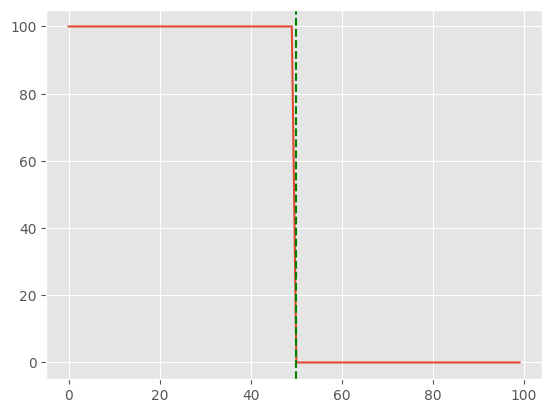

In [24]:
gain_list, bkp, gain = optimal_cp_ls(y_, 0, len(y_)-1)
plt.plot(x_,y_)
plt.axvline(x = max(gain_list)[1], color = 'g', linestyle = '--')

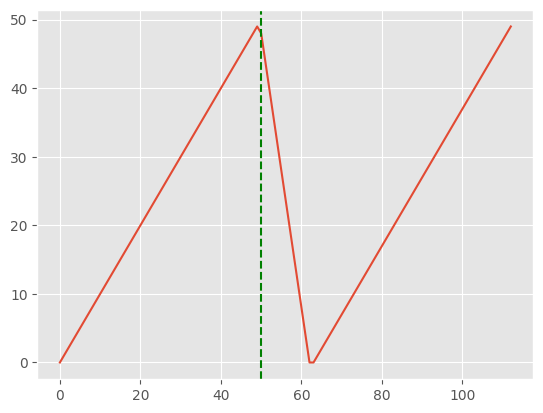

In [25]:
gain_list, bkp, gain = optimal_cp_ls(y__, 0, len(y__)-1)
plt.plot(x__,y__)
plt.axvline(x = max(gain_list)[1], color = 'g', linestyle = '--')

It works as it is hoped, so let's generalyze the algorithm.

In [43]:
import itertools

iterator1, iterator2 = itertools.tee([1,2,3,4,5,6,7])

next(iterator2, None)
zipped = zip(iterator1,iterator2)
print(list(zipped))

[(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7)]
[]


In [27]:
# utils

from itertools import tee
from math import ceil

def pairwise(iterable):
    """s -> (s0,s1), (s1,s2), (s2, s3), ..."""
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def unzip(seq):
    """Reverse zip."""
    return zip(*seq)

def sum_of_costs(self, bkps):
    """Returns the sum of segments cost for the given segmentation.

    Args:
        bkps (list): list of change points. By convention, bkps[-1]==n_samples.

    Returns:
        float: sum of costs
    """
    soc = sum(self.error(start, end) for start, end in pairwise([0] + bkps))
    return soc

In [28]:
def bin_seg(signal, n_bkps=None, pen=None, epsilon=None):

        signal_ = deepcopy(signal)
        signal_ = signal_.reshape(-1, 1)
        n_samples, _ = signal_.shape
        strides = (signal_.itemsize, signal_.itemsize)
        order = 2
        shape = (n_samples - order, order)
        lagged = as_strided(signal_, shape=shape, strides=strides)
        lagged_after_padding = np.pad(lagged, ((order, 0), (0, 0)), mode="edge")
        covar = np.c_[lagged_after_padding, np.ones(n_samples)]
        signal_[: order] = signal_[order]

        # initialization
        bkps = [n_samples]
        stop = False
        while not stop:
            stop = True
            new_bkps = [
                optimal_cp_ls(start, end) for start, end in pairwise([0] + bkps)
            ]
            bkp, gain = max(new_bkps, key=lambda x: x[1])

            if bkp is None:  # all possible configuration have been explored.
                break

            if n_bkps is not None:
                if len(bkps) - 1 < n_bkps:
                    stop = False
            elif pen is not None:
                if gain > pen:
                    stop = False
            elif epsilon is not None:
                error = sum_of_costs(bkps)
                if error > epsilon:
                    stop = False

            if not stop:
                bkps.append(bkp)
                bkps.sort()
        partition = {
            (start, end): least_squares(start, end)
            for start, end in pairwise([0] + bkps)
        }
        return partition

## 2. Monotony algorithm

In [29]:
y_d0_ps = y_d0.reshape((len(y_d0),1))
y_d1_ps = y_d1.reshape((len(y_d1),1))

df_0 = pd.DataFrame(y_d0_ps,columns=['dataset'])
df_1 = pd.DataFrame(y_d1_ps,columns=['dataset'])

* Syntethic dataset 0

In [ ]:
df_0['next'] = df_0['dataset'][1:].tolist() + [np.nan]
df_0['diff'] = df_0['next'] - df_0['dataset']
df_indexes_d0 = df_0[df_0['diff']<0]
df_indexes_d0['index'] = df_indexes_d0.index
df_indexes_d0['next_index'] = df_indexes_d0['index'][1:].tolist() + [np.nan]
df_indexes_d0['diff_index'] = df_indexes_d0['next_index'] - df_indexes_d0['index']
indexes = df_indexes_d0[df_indexes_d0['diff_index']>1].index.tolist()
indexes_prev = df_indexes_d0[df_indexes_d0['diff_index']>1]['next_index'].astype(int).tolist()
first_and_last = [df_indexes_d0.reset_index(drop=True)['index'].tolist()[0],df_indexes_d0.reset_index(drop=True)['index'].tolist()[-1]]

<ipython-input-56-8d323414449f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_indexes_d0['index'] = df_indexes_d0.index
<ipython-input-56-8d323414449f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_indexes_d0['next_index'] = df_indexes_d0['index'][1:].tolist() + [np.nan]
<ipython-input-56-8d323414449f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

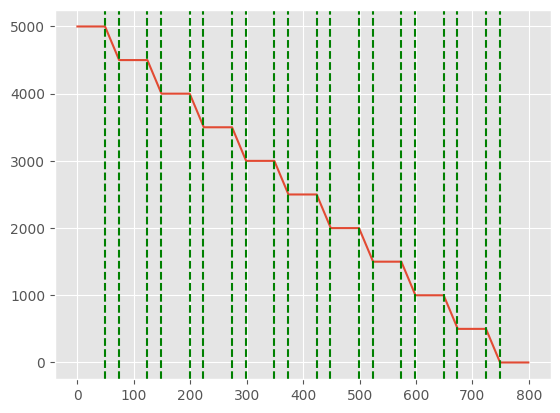

In [ ]:
plt.plot(df_0.index,df_0['dataset'])
for index in indexes:
  plt.axvline(x = index, color = 'g', linestyle = '--')
for index in indexes_prev:
  plt.axvline(x = index, color = 'g', linestyle = '--')
for index in first_and_last:
  plt.axvline(x = index, color = 'g', linestyle = '--')
plt.show()

* Synthetic dataset 1

In [ ]:
df_1['next'] = df_1['dataset'][1:].tolist() + [np.nan]
df_1['diff'] = df_1['next'] - df_1['dataset']
df_indexes_d1 = df_1[df_1['diff']<0]
df_indexes_d1['index'] = df_indexes_d1.index
df_indexes_d1['next_index'] = df_indexes_d1['index'][1:].tolist() + [np.nan]
df_indexes_d1['diff_index'] = df_indexes_d1['next_index'] - df_indexes_d1['index']
indexes = df_indexes_d1[df_indexes_d1['diff_index']>1].index.tolist()
indexes_prev = df_indexes_d1[df_indexes_d1['diff_index']>1]['next_index'].astype(int).tolist()
first_and_last = [df_indexes_d1.reset_index(drop=True)['index'].tolist()[0],df_indexes_d1.reset_index(drop=True)['index'].tolist()[-1]]

<ipython-input-64-7935b4fe8b97>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_indexes_d1['index'] = df_indexes_d1.index
<ipython-input-64-7935b4fe8b97>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_indexes_d1['next_index'] = df_indexes_d1['index'][1:].tolist() + [np.nan]
<ipython-input-64-7935b4fe8b97>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

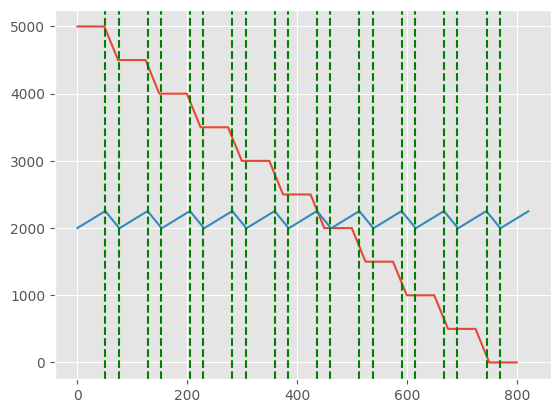

In [ ]:
plt.plot(df_0.index,df_0['dataset'])
plt.plot(df_1.index,df_1['dataset'])
for index in indexes:
  plt.axvline(x = index, color = 'g', linestyle = '--')
for index in indexes_prev:
  plt.axvline(x = index, color = 'g', linestyle = '--')
for index in first_and_last:
  plt.axvline(x = index, color = 'g', linestyle = '--')
plt.show()